<h3> Imports </h3>

In [1]:
import numpy as np
import pandas as pd
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
print('Libraries imported successfully!')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Libraries imported successfully!


<h3> Important Variables and Methods for Algorithm Functionality </h3>

In [124]:
atom_dict = {"00":"H", "01":"C", "10":"O", "11":"N"}

pi = math.pi
shots = 1024

num_of_atoms = 1
bits_per_atom = 2
bits_per_coord = 6
sign_bit = 1
num_of_total_bits = num_of_atoms*(bits_per_atom+3*(sign_bit+bits_per_coord))

print(f"Total number of bits per atom: {int(num_of_total_bits/num_of_atoms)}")

Total number of bits per atom: 23


In [126]:
def binaryToDecimal(binary):
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal  

def whichAtom(atom, num_of_qubits, dictionary):
    return dictionary[atom]

def calcDistance(coord_dist, num_of_qubits, sign):
    distance = binaryToDecimal(coord_dist)/(2**(num_of_qubits-2))
    if sign == 1:
        distance *= -1;
    return distance

def experiment(shots):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(atom_qc,backend, shots = shots)
    result = job.result()

    counts = result.get_counts()
    return counts

In [147]:
#### Determine range of numbers and corresponding precision
num = 101011
maxNum = 111111
numLen = len(str(num))
dist = calcDistance(num, numLen-1, 0)
maxDist = calcDistance(maxNum, numLen-1, 0)
print("Sample number: BIN",binaryToDecimal(num),"--> Float",dist,"\n")
print(f"Range and Precision: 0.0 to {maxDist}")

Sample number: BIN 43 --> Float 5.375 

Range and Precision: 0.0 to 7.875


<h3> Sample Circuit and Test Run (to test code only) </h3> 

<b>Constructing the Quantum Circuit</b> (will come from the Quantum Generator)

Sample Quantum Circuit


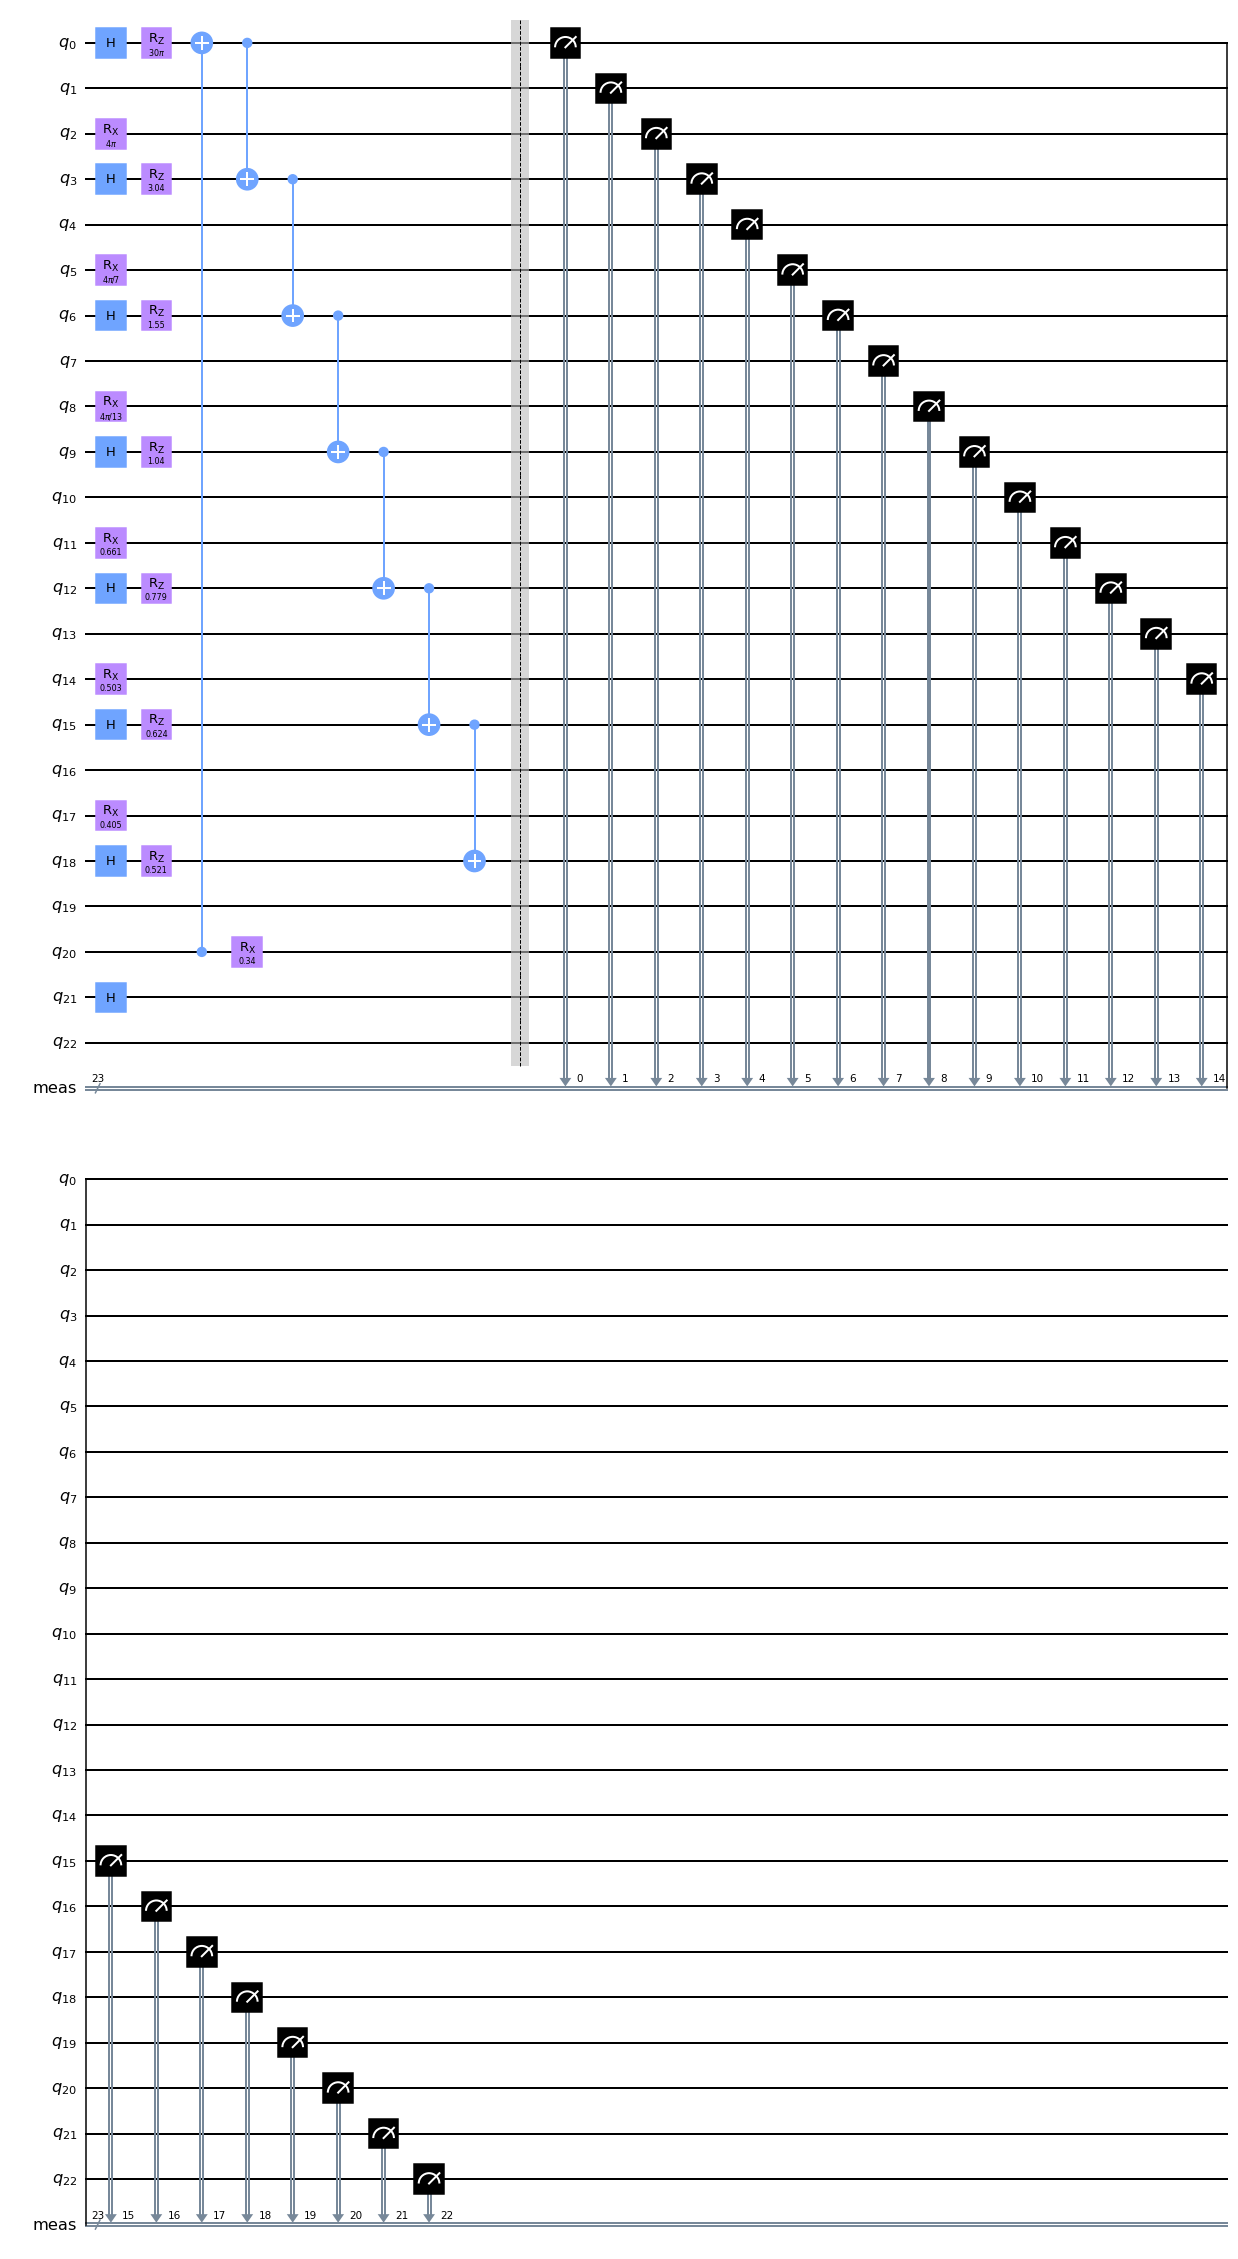

In [154]:
#### Sample Quantum Circuit
print("Sample Quantum Circuit")

atom_qc = QuantumCircuit(num_of_total_bits)
atom_qc.h([i for i in range(0,num_of_total_bits,3)])

for q_idx in range(0,num_of_total_bits-2,3):
    atom_qc.rz(3*pi/(q_idx+0.1), q_idx)
    atom_qc.rx(2*pi/(q_idx+0.5), q_idx+2)
    atom_qc.cx(q_idx-3, q_idx)
atom_qc.measure_all()
atom_qc.draw()

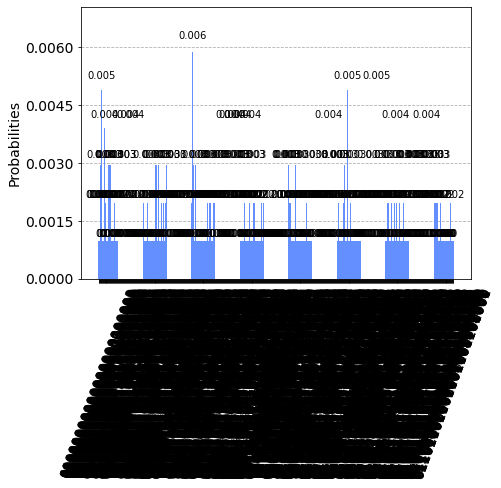

In [150]:
#### Sample Simulation

counts = experiment(shots)
plot_histogram(counts)

<h3> Main Algorithm (Variables defined at top) </h3>

In [151]:
maxVal = -1
for value in counts.values():
    if value > maxVal:
        maxVal = value
maxKey = list(counts.keys())[list(counts.values()).index(maxVal)][::-1]
#print(maxKey)

In [152]:
molecule_gen_xyz = pd.DataFrame(columns=["atom", "x", "y", "z"])

interval = bits_per_atom+3*(sign_bit+bits_per_coord)
max_molecule_length = 11

do = True

for char_index in range(0, len(maxKey), interval):
    substring = maxKey[char_index:char_index+interval]
    
    sign_x = 1 if (int(substring[0]) == 1) else 0
    sign_y = 1 if (int(substring[1]) == 1) else 0
    sign_z = 1 if (int(substring[2]) == 1) else 0
    
    atom_bit_str = substring[0:bits_per_atom]
    x_coord = int(substring[bits_per_atom:bits_per_atom+bits_per_coord])
    y_coord = int(substring[bits_per_atom+bits_per_coord:bits_per_atom+2*bits_per_coord])
    z_coord = int(substring[bits_per_atom+2*bits_per_coord:bits_per_atom+3*bits_per_coord])

    atom = whichAtom(atom_bit_str, bits_per_atom, atom_dict)
    x_dist = calcDistance(x_coord, bits_per_coord, sign_x)
    y_dist = calcDistance(y_coord, bits_per_coord, sign_y)
    z_dist = calcDistance(z_coord, bits_per_coord, sign_z)
        
    new_row = {'atom':atom, 'x':x_dist, 'y':y_dist, 'z':z_dist}
    molecule_gen_xyz = molecule_gen_xyz.append(new_row, ignore_index=True)

if int(len(maxKey)/interval) < max_molecule_length:
    num_zero_rows = max_molecule_length-int(len(maxKey)/interval)
    new_row = {'atom':0, 'x':0.0, 'y':0.0, 'z':0.0}
    for i in range(num_zero_rows):
        molecule_gen_xyz = molecule_gen_xyz.append(new_row, ignore_index=True)

In [153]:
molecule_gen_xyz

,atom,x,y,z
0,O,-0.25,0.0,0.125
1,0.0,0.00,0.0,0.000
2,0.0,0.00,0.0,0.000
3,0.0,0.00,0.0,0.000
4,0.0,0.00,0.0,0.000
5,0.0,0.00,0.0,0.000
6,0.0,0.00,0.0,0.000
7,0.0,0.00,0.0,0.000
8,0.0,0.00,0.0,0.000
9,0.0,0.00,0.0,0.000


In [ ]:
molecule_gen_xyz.to_csv("mol_gen_xyz.csv")